# Modelagem Epidemiológica da COVID-19 com o Modelo SIR
## Ajuste direto de parâmetros via `lmfit.Model`

Este notebook apresenta a modelagem da dinâmica da COVID-19 em Belém (PA) utilizando o modelo epidemiológico *SIR*.

## 1. Objetivo

O objetivo deste estudo é **Testar o ajuste do modelo epidemiológico do tipo SIR** aos dados observados da COVID-19, considerando os primeiros 120 dias da pandemia (primeira onda).

Especificamente, busca-se:
- estimar os parâmetros β (transmissão) e γ (recuperação)
- avaliar a capacidade do modelo SIR em reproduzir a evolução dos casos acumulados;
- comparar visualmente o ajuste do modelo aos dados reais.

O estudo é aplicado ao estado do **Pará**, com dados agregados a partir de registros municipais.



In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
import warnings
import modelos_epidemiologicos as model #

## leitura dos dados

In [12]:
df0= pd.read_parquet("/home/akel/PycharmProjects/Endemic_model/data/caso_full.parquet")

#df0= pd.read_parquet("/home/akel/PycharmProjects/Endemic_model/brainstorms/caso_full.parquet")
df0['date']=pd.to_datetime(df0['date'],format='%Y-%m-%d')
dfbel= df0[(df0["city"] == "Belém") & (df0['state']=='PA') ]

## Visualização previa

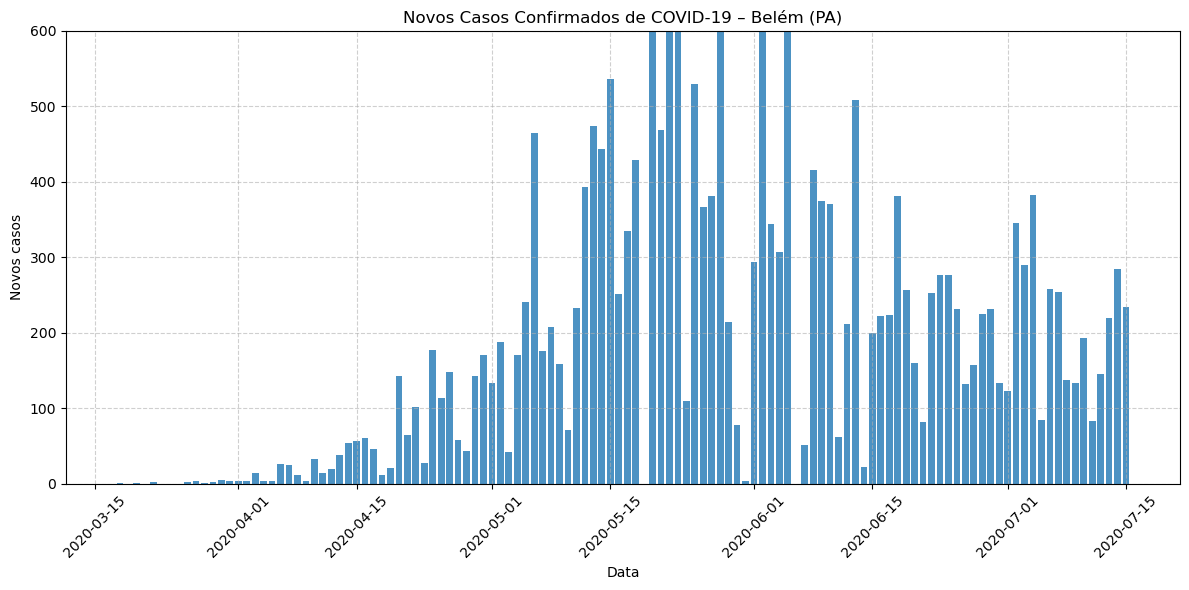

In [27]:
nd = 120
c = dfbel['new_confirmed'].iloc[:nd].values
t = np.arange(nd)

plt.figure(figsize=(12, 6))
plt.bar(dfbel['date'].iloc[:nd].values,
        c,
        alpha=0.8)

plt.title('Novos Casos Confirmados de COVID-19 – Belém (PA)')
plt.xlabel('Data')
plt.ylabel('Novos casos')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(0, 600)
plt.show()

c = dfbel['new_confirmed'].iloc[:nd].values
c2 = np.diff(c, prepend=0)

## Modelo SIR e Formulação do Problema Inverso

O modelo SIR clássico descreve a evolução temporal de uma epidemia por meio de três compartimentos: suscetíveis (S(t)), infectados (I(t)) e recuperados (R(t)). A dinâmica do sistema é governada pelas equações diferenciais ordinárias:

\begin{aligned}
\frac{dS}{dt} &= -\beta \frac{S I}{N}, \
\frac{dI}{dt} &= \beta \frac{S I}{N} - \gamma I, \
\frac{dR}{dt} &= \gamma I,
\end{aligned}


onde ( $\beta$ ) é a taxa de transmissão, ( $\gamma$ ) a taxa de recuperação e ( N ) a população efetiva.

O sistema é integrado numericamente por meio do método `odeint`. Para a calibração do modelo aos dados observados de incidência diária, a variável ajustada não é o número de infectados ativos (I(t)), mas o fluxo de novos casos, definido por:

$ \lambda(t) = \beta \frac{S(t),I(t)}{N} $

A estimação dos parâmetros epidemiológicos é tratada como um **problema inverso de mínimos quadrados não lineares**, no qual se busca minimizar a discrepância entre a incidência observada ( c(t_i) ) e a incidência simulada pelo modelo SIR ($\lambda(t_i;\boldsymbol{\theta})$ ). O problema é formulado como a minimização do funcional:


$$\min_{ \boldsymbol{\theta}} \Phi(\boldsymbol{\theta})=
\frac{1}{2}
\sum_{i=1}^{n}
\left[
c(t_i) - \lambda(t_i,\boldsymbol{\theta})
\right]^2,
$$


onde:

* ( t_i ) são os instantes de observação,
* ( c(t_i) ) representa os dados observados de casos incidentes,
* ( \lambda(t_i;\boldsymbol{\theta}) = \beta \dfrac{S(t_i) I(t_i)}{N} ) é a saída do modelo,
* ( S(t_i) ) e ( I(t_i) ) são obtidos pela integração numérica do sistema SIR.
*  e $\boldsymbol{\theta} = (\beta,\ \gamma,\ I_0,\ N)$

Como a dependência de ( $\lambda(t;\boldsymbol{\theta})$ ) em relação aos parâmetros é não linear, o problema não admite solução analítica. Assim, a minimização é realizada por meio do algoritmo **Levenberg–Marquardt**, que combina as propriedades do método de Gauss–Newton e do gradiente descendente, garantindo robustez e rápida convergência mesmo em regiões mal condicionadas do espaço paramétrico.

Na implementação computacional aqui éresolvida pela chamada:

```python
#chamada
result = mod.fit(c, params, method="leastsq", t=t)
```

em que o vetor de resíduos utilizado pelo algoritmo é definido por:

$$
r_i(\boldsymbol{\theta}) = c(t_i) - \lambda(t_i;\boldsymbol{\theta}),
$$

sendo atualizado iterativamente até que um critério de convergência baseado na redução do erro quadrático seja satisfeito.



[[Model]]
    Model(model_sir)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 87
    # data points      = 120
    # variables        = 4
    chi-square         = 2359278.40
    reduced chi-square = 20338.6069
    Akaike info crit   = 1194.36496
    Bayesian info crit = 1205.51492
    R-squared          = 0.45466380
[[Variables]]
    N:      29364.5503 +/- 121964.326 (415.35%) (init = 100000)
    beta:   0.12894952 +/- 0.97573739 (756.68%) (init = 0.3)
    gamma:  0.05790171 +/- 0.96187872 (1661.23%) (init = 0.1)
    I0:     81.7825895 +/- 674.142018 (824.31%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) = +1.0000
    C(N, gamma)    = +0.9997
    C(N, beta)     = +0.9996
    C(beta, I0)    = -0.9984
    C(gamma, I0)   = -0.9980
    C(N, I0)       = -0.9965


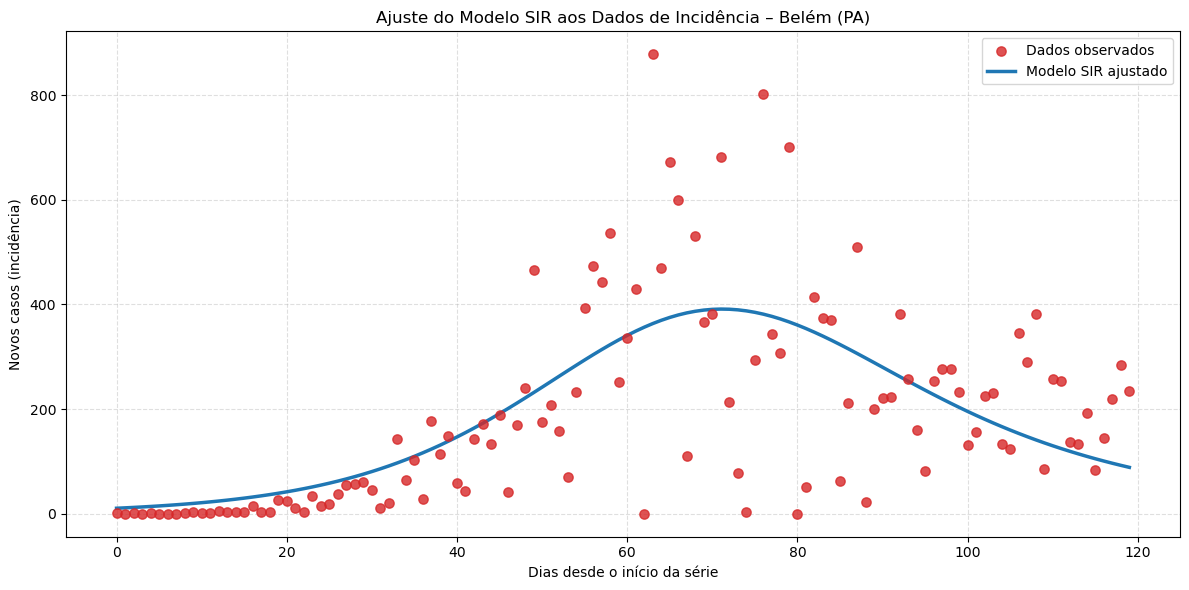

In [28]:
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

def model_sir(t, N, beta, gamma, I0):
    y0 = [N - I0, I0, 0]
    out = odeint(sir_model, y0, t, args=(N, beta, gamma))
    S, I, R = out.T
    incidence = beta * S * I / N
    return incidence

mod = lmfit.Model(model_sir)

mod.set_param_hint("N", value=100000, min=10000, max=500000)
mod.set_param_hint("beta", value=0.3, min=0.01, max=2)
mod.set_param_hint("gamma", value=0.1, min=0.01, max=1)
mod.set_param_hint("I0", value=10, min=1, max=500)

params = mod.make_params()

# Vetor temporal (dias)
t = np.linspace(0, nd - 1, nd)

# Ajuste do modelo SIR à incidência observada
result = mod.fit(c, params, method="leastsq", t=t)

# Relatório do ajuste
print(result.fit_report())

# Visualização do ajuste
plt.figure(figsize=(12, 6))

plt.scatter(
    t, c,
    color='tab:red',
    s=45,
    alpha=0.8,
    label='Dados observados',
    zorder=3
)

plt.plot(
    t, result.best_fit,
    color='tab:blue',
    lw=2.5,
    label='Modelo SIR ajustado'
)

plt.xlabel('Dias desde o início da série')
plt.ylabel('Novos casos (incidência)')
plt.title('Ajuste do Modelo SIR aos Dados de Incidência – Belém (PA)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


## Considerações Finais

O modelo SIR, quando corretamente ajustado à incidência, fornece uma descrição coerente da dinâmica epidêmica em Belém no período inicial analisado.

A forte correlação entre parâmetros é inerente à estrutura do modelo e aos dados disponíveis, reforçando que o principal parâmetro identificável é o número básico de reprodução R₀.

Apesar de suas simplificações, o SIR serve como modelo base para extensões mais realistas, como SIRC ou SEIR, que podem capturar melhor aspectos como latência, controle e mudanças comportamentais.